In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [77]:
import glob
import os.path
import re
import pandas as pd
import seaborn as sns

# `torch-rnn` grid search

In [348]:
torch_logs = '/home/fl350/data/torch_logs'

confs = dict()
train = dict()
val = dict()
for log_path in glob.glob(os.path.join(torch_logs, '*.log')):
    conf = dict()
    for param in re.split(r'[,\s]*', os.path.basename(log_path)[:-4]):
        k, v = param.split('=')
        conf[k] = float(v)
        
    train_list = []
    val_list = []
    with open(log_path, 'r') as log:
        prev_epoch = None
        for line in log:
            if line[:5] == 'Epoch':
                values = re.split(r'[,\s]*', line)
                train_list.append({
                        'epoch': float(values[1]),
                        'loss': float(values[-2])
                    })
                prev_epoch = train_list[-1]['epoch']
            if line[:3] == 'val':
                val_list.append({
                        'epoch': prev_epoch,
                        'loss': float(line.split()[-1])
                    })
    train[log_path] = pd.DataFrame(train_list, columns=['epoch', 'loss'])
    val[log_path] = pd.DataFrame(val_list, columns=['epoch', 'loss'])
    confs[log_path] = conf
confs = pd.DataFrame(confs).T

## Enumerate all performance results

In [349]:
config_perfs = (confs
                .loc[[log_path for log_path in confs.index if len(val[log_path]['loss']) != 0]]
                .assign(val_metric=lambda df: map(lambda x: val[x]['loss'].iloc[-1], df.index),
                        train_metric=lambda df: map(lambda x: train[x]['loss'].iloc[-10:].mean(), df.index))
                .sort_values(['val_metric', 'train_metric']))
with open('torch-rnn-config-perfs.tex', 'wb') as f:
    f.write(
        config_perfs[[
                'num_layers',
                'rnn_size',
                'seq_length',
                'wordvec',
                'train_metric',
                'val_metric']].to_latex(index=False,longtable=True))

## Sensitivity to network parameters `num_layers` and `rnn_size`

 * Larger `rnn_size` leads to higher capacity and lower training loss
     * Presents as overfitting on validation, where the lowest capacity model `rnn_size` appears to be improving in generalization while others are flat/increasing
 * Training curves about the same wrt `num_layers`, validation curves have interesting story
     * Depth matters: small `64` and `128` hidden unit RNNs saw improvements up to `0.09`
     * Expressivity gained from depth furthers overfitting: `256` hidden unit RNN has some of the best validation performance at depth `1` but is the worst generalizing model for depths `2` and `3` even though training loss is low
 * `rnn_size=128` undisputably best generalizing, optimized at `num_layers=2`: will continue with these settings

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


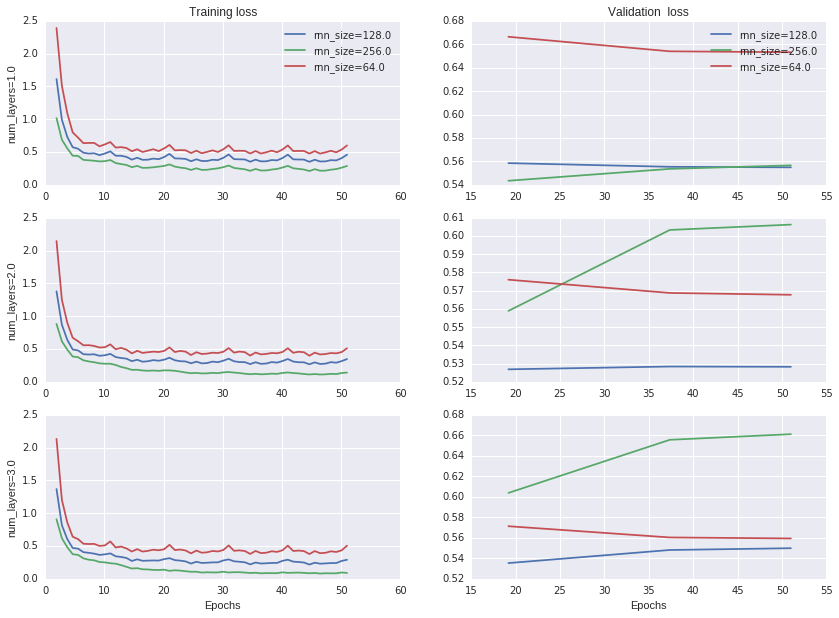

In [350]:
confs_subset = confs[
    confs['wordvec'] == 64][
    confs['seq_length'] == 128]
row_vars = set(confs_subset['num_layers'])
nrows = len(row_vars)
plt.figure(figsize=(14,10))
for i,row_var in enumerate(sorted(row_vars)):
    facet_subset = confs_subset[confs_subset['num_layers'] == row_var].index
    for log_path in facet_subset:
        lab = 'rnn_size={}'.format(confs.loc[log_path]['rnn_size'])
        plt.subplot(nrows,2,2*i+1)
        plt.plot(train[log_path]['epoch'], train[log_path]['loss'], label=lab)
        plt.ylabel('num_layers={}'.format(row_var))
        plt.subplot(nrows,2,2*i+2)
        plt.plot(val[log_path]['epoch'], val[log_path]['loss'], label=lab)
    
plt.subplot(nrows,2,1)
plt.title('Training loss')
plt.legend()
plt.subplot(nrows,2,2)
plt.title('Validation  loss')
plt.legend()
plt.subplot(nrows,2,2*nrows-1)
plt.xlabel('Epochs')
plt.subplot(nrows,2,2*nrows)
plt.xlabel('Epochs')

plt.savefig('torch-rnn-network-params.png')
plt.show()

## Sensitivity to network input parameters `seq_length` and `wordvec`

* Training losses are about the same across all `wordvec`s
* Validation losses suggest that increasing `seq_length` important for good performance (**TODO**: investigate further)
* `wordvec=128` overfits for all cases, the other two depend on `seq_length` and vary an order of magnitude smaller than the performance gains from increasing `seq_length`

/home/fl350/.pyenv/versions/2.7.11/envs/jupyter/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


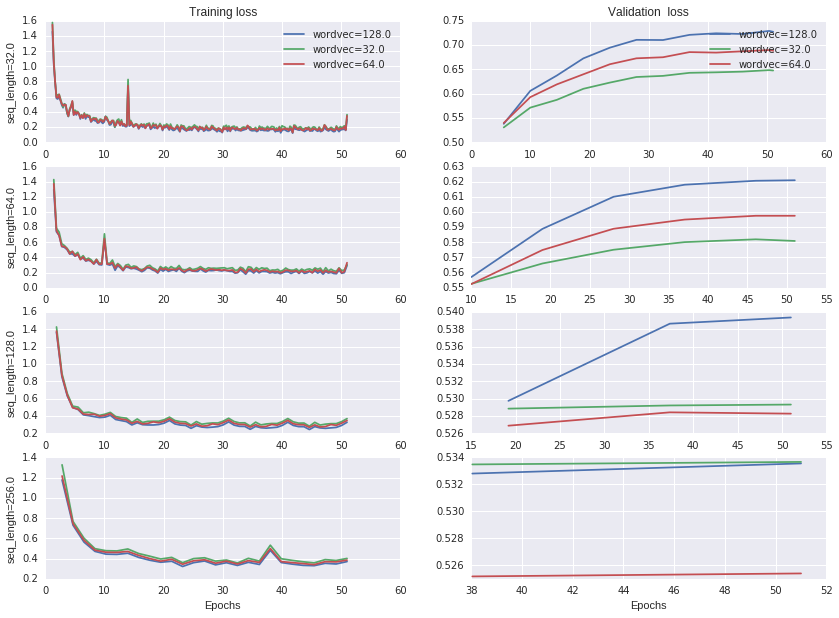

In [351]:
confs_subset = confs[
    confs['rnn_size'] == 128][
    confs['num_layers'] == 2]
row_vars = set(confs_subset['seq_length'])
nrows = len(row_vars)
plt.figure(figsize=(14,10))
for i,row_var in enumerate(sorted(row_vars)):
    facet_subset = confs_subset[confs_subset['seq_length'] == row_var].index
    for log_path in facet_subset:
        if val[log_path].size == 0:
            continue
        lab = 'wordvec={}'.format(confs.loc[log_path]['wordvec'])
        plt.subplot(nrows,2,2*i+1)
        plt.plot(train[log_path]['epoch'], train[log_path]['loss'], label=lab)
        plt.ylabel('seq_length={}'.format(row_var))
        plt.subplot(nrows,2,2*i+2)
        plt.plot(val[log_path]['epoch'], val[log_path]['loss'], label=lab)
    
plt.subplot(nrows,2,1)
plt.title('Training loss')
plt.legend()
plt.subplot(nrows,2,2)
plt.title('Validation  loss')
plt.legend()
plt.subplot(nrows,2,2*nrows-1)
plt.xlabel('Epochs')
plt.subplot(nrows,2,2*nrows)
plt.xlabel('Epochs')

plt.savefig('torch-rnn-input-params.png')
plt.show()

# Theanets RNN search

In [352]:
theanets_data = '/home/fl350/bachbot/scratch/theanets_cv/'

In [353]:
import pickle
losses_t = pickle.load(open(theanets_data + 'losses_t.pkl', 'rb'))
losses_v = pickle.load(open(theanets_data + 'losses_v.pkl', 'rb'))

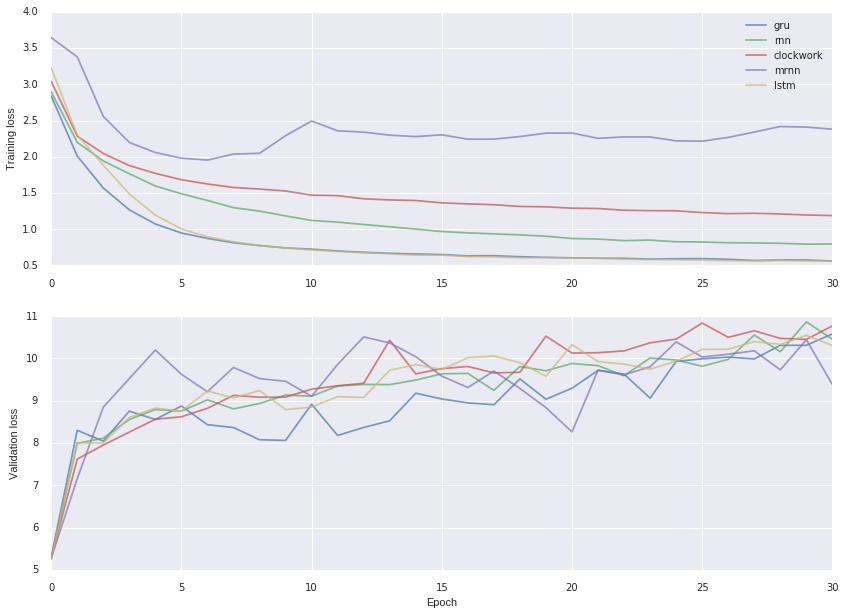

In [371]:
plt.figure(figsize=(14,10))
for i, form in enumerate(losses_t.keys()):
    if form in ['scrn']:
        continue
    plt.subplot(2,1,1)
    plt.plot(losses_t[form], label=form, alpha=0.7)

    plt.subplot(2,1,2)
    plt.plot(losses_v[form], label=form, alpha=0.7)
    
for subplot in range(1,3):
    plt.subplot(2,1,subplot)

    plt.gca().xaxis.tick_bottom()
    plt.gca().yaxis.tick_left()
    plt.gca().spines['top'].set_color('none')
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['bottom'].set_position(('outward', 6))
    plt.gca().spines['left'].set_position(('outward', 6))

    if subplot == 1:
        plt.legend()
        plt.gca().set_ylabel('Training loss')
    else:
        plt.gca().set_ylabel('Validation loss')
        plt.gca().set_xlabel('Epoch')

plt.savefig('theanets-architecture.png')
plt.show()